# CIFAR 10 dataset


In this notebook I will show how to tackle CIFAR 10 dataset using a simple 3 convolutional layer network. Later I will demonstrate how to use Transfer Learning to improve the network performance. In overall, the steps are the following: 

<ol> 
  <li> Introduction
  <li> Description of the CIFAR 10 dataset 
  <li> Dataset transformation
  <li> Run of a simple model
  <li> VGG Transfer Learning
  <li> ResNet Transfer Learning
  <li> Conclusion
</ol>

## Introduction

Simple Convolutional networks don't have a good performance on complex datasets, such as CIFAR 100. To tackle this kind of datasets more complex networks are used. Usually, these networks require very long learning time. Luckily, Transfer Learning allows to speed up the process using pretrained networks. Let's have a look into an example: <img src ="https://www.learnopencv.com/wp-content/uploads/2019/05/transfer-learning-768x431.jpg">
<br>
Here the are 2 different networks which are used for similar, but different tasks. The one above is already pretrained, That means that it was learned on some dataset in advance. The idea behind transfer learning is to reuse some layers with weights from the network above and use them for the network below. In this case, the network below needs to learn the weights only for few custom layers. As a result, it needs less data for solving the task and requires less time too. It's great, isn't it?!

## Description of the CIFAR 10 dataset 


To demonstrate transfer learning CIFAR 10 dataset is used. Let's import it and have a look what is inside! 

In [ ]:
# import libraries
import torch
import torchvision

In [ ]:
# import dataset
dataset = torchvision.datasets.CIFAR10('sample_data/', train=True, download=True)

Extracting sample_data/cifar-10-python.tar.gz to sample_data/


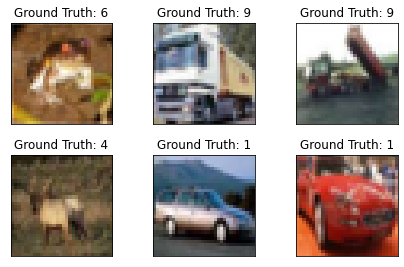

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(dataset[i][0], interpolation='none')
    plt.title("Ground Truth: {}".format(dataset[i][1]))
    plt.xticks([])
    plt.yticks([])

So thera are different types of images there. On the first image there's some animal, on the bottom right image there's a phone. CIFAR 100 contains 10 different classes. Let's see their distribution.

In [ ]:
from collections import Counter
targets = []
for i, (image, target) in enumerate(dataset):
  targets.append(target)
Counter(targets)

Counter({0: 5000,
         1: 5000,
         2: 5000,
         3: 5000,
         4: 5000,
         5: 5000,
         6: 5000,
         7: 5000,
         8: 5000,
         9: 5000})

So there are 5000 images for each of the class. We don't need to perform any additional analysis. Let's proceed with image transformations.


In [ ]:
# clean memory
del dataset
del targets

## Dataset transformation

In [ ]:
# define parameters 
n_epochs = 200
batch_size_train = 256
batch_size_test = 2000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
# reuse parameters for normalization from https://zhenye-na.github.io/2018/10/07/pytorch-resnet-cifar100.html
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('sample_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.RandomCrop(32, padding=4),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                    mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
                            ])),
  batch_size=batch_size_train, shuffle=True, num_workers=4)
# num_workers = #num_gpus * gpu_throughtput / (batch_size * size_of_one_input)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('sample_data//', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                    mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
                             ])),
  batch_size=batch_size_test, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


There are 4 transformations which are randomly applied to the images on each epoch:

1.   Random Crop
2.   Random Horizontal Flip
3.   Tensor
4.   Normalize

The original dimension of images is 32*32*3. The first transformation pads an input image with 4 zeros to all dimensions(which means the image 36*36*3) and then selects 32*32 part of new image).

The second transformation does a horizontal flip with a probability 50%.  

The third transformation changes the input type from PIL to tensor

The last transformation normalized values for each of the channels


## Run of a simple model with 2 convolutional layers



Let's use a simple model with 2 convolutional layers. INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC. Notice, that I also added dropout layers



In [ ]:
# import libraries
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.dropout = nn.Dropout(p=0.2)
        self.maxpool = nn.MaxPool2d(2)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()
        
        # increase channels to 64
        self.conv1 = nn.Conv2d(3, 64, (5, 5), padding=2)
        
        self.conv2 = nn.Conv2d(64, 128, (3, 3), padding=1)
        
        self.linear1 = nn.Linear(8192, 1024)

        self.linear2 = nn.Linear(1024, 512)
        
        self.linear3 = nn.Linear(512, 10)
        
    def forward(self, x):
        # change order of layer
        # remove dropout
        x = self.dropout(self.conv1(x))
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.dropout(self.conv2(x))
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.dropout(self.relu(x))
        x = self.dropout(self.relu(self.linear2(x)))
        output = self.linear3(x)

        return output

In [ ]:
def train(epoch, network, optimizer, train_losses, train_counter):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = network(data)
        loss = nn.CrossEntropyLoss(reduction="mean")(output, target)
        loss.backward()
        # after step is called, all parameters in the optimizer are updated using the result of loss function
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(network.state_dict(), '/home/maksim.hrytsenia/ENX_projects/data/model.pth')
            #torch.save(optimizer.state_dict(), '/home/maksim.hrytsenia/ENX_projects/data/results/optimizer.pth')

In [ ]:
def test(network, test_losses, test_counter):
  # eval is needed for multiple layers to specify that there's a test mode. Useful for example for dropout
    network.eval()
    test_loss = 0
    correct = 0
    # specify that there's no need to cache intermediate results
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target = target.cuda()
            output = network(data)
            test_loss += nn.CrossEntropyLoss(reduction="sum")(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_losses.append(test_loss)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss / len(test_loader.dataset), correct, len(test_loader.dataset), accuracy))
    return test_loss / len(test_loader.dataset)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

initial_patience = 10
patience = initial_patience
min_loss = 10000

network = ConvNet()
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
                      

for epoch in range(1, n_epochs + 1):
    if patience == 0:
        break
    train(epoch, network, optimizer, train_losses, train_counter)
    test_loss = test(network, test_losses, test_counter)
    if test_loss > min_loss:
        patience = initial_patience
        min_loss = test_loss
    else:
        patience -= 1

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301820
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.294422
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.277124
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.293271
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.277167
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.249126
Train Epoch: 1 [15360/50000 (31%)]	Loss: 2.235167
Train Epoch: 1 [17920/50000 (36%)]	Loss: 2.191699
Train Epoch: 1 [20480/50000 (41%)]	Loss: 2.186806
Train Epoch: 1 [23040/50000 (46%)]	Loss: 2.172293
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.113510
Train Epoch: 1 [28160/50000 (56%)]	Loss: 2.089716
Train Epoch: 1 [30720/50000 (61%)]	Loss: 2.072773
Train Epoch: 1 [33280/50000 (66%)]	Loss: 2.088936
Train Epoch: 1 [35840/50000 (71%)]	Loss: 2.006574
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.014605
Train Epoch: 1 [40960/50000 (82%)]	Loss: 2.073015
Train Epoch: 1 [43520/50000 (87%)]	Loss: 1.957307
Train Epoch: 1 [46080/50000 (92%)]	Loss: 2.000290
Train Epoch: 1 [48640/50000 (97%)]	Loss: 2.012286

Test set

## Run of a model with 3 convolutional layers

Let's try the following architecture INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC



In [ ]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        self.dropout = nn.Dropout(p=0.2)
        self.maxpool = nn.MaxPool2d(2)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

        # increase channels to 64
        self.conv1_1 = nn.Conv2d(3, 64, (5, 5), padding=2) # 32*32*64

        # Notice that because I add the stripe, my input dimensionality is reduced
        self.conv1_2 = nn.Conv2d(64, 64, (3, 3), padding=1) # 32 * 32 * 64
        self.batch1 = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, (3, 3), padding=1) # 16*16*128
        
        self.conv2_2 = nn.Conv2d(128, 128, (3, 3), padding=1) # 16 * 16 * 128
        self.batch2 = nn.BatchNorm2d(128)

        self.conv3_1 = nn.Conv2d(128, 256, (3, 3), padding=1) # 8*8*256

        self.conv3_2 = nn.Conv2d(256, 256, (3, 3), padding=1) # 8 * 8 * 256
        self.batch3 = nn.BatchNorm2d(256)
        
        self.linear1 = nn.Linear(4096, 1024) # 4 * 4 * 256

        self.linear2 = nn.Linear(1024, 512)
        
        self.linear3 = nn.Linear(512, 10)
        
    def forward(self, x):
        # change order of layer
        # remove dropout
        x = self.dropout(self.conv1_1(x))
        x = self.relu(x)
        x = self.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = self.batch1(x)
        
        x = self.dropout(self.conv2_1(x))
        x = self.relu(x)
        x = self.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = self.batch2(x)


        x = self.dropout(self.conv3_1(x))
        x = self.relu(x)
        x = self.relu(self.conv3_2(x))
        x = self.maxpool(x)
        x = self.batch3(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.dropout(self.relu(x))
        x = self.dropout(self.relu(self.linear2(x)))
        output = self.linear3(x)

        return output

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

initial_patience = 10
patience = initial_patience
min_loss = 10000

network = ConvNet3()
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
                      

for epoch in range(1, n_epochs + 1):
    if patience == 0:
        break
    train(epoch, network, optimizer, train_losses, train_counter)
    test_loss = test(network, test_losses, test_counter)
    if test_loss > min_loss:
        patience = initial_patience
        min_loss = test_loss
    else:
        patience -= 1

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.313343
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.291777
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.270471
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.215176
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.150863
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.124409
Train Epoch: 1 [15360/50000 (31%)]	Loss: 2.037785
Train Epoch: 1 [17920/50000 (36%)]	Loss: 2.040183
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.950522
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.913205
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.885219
Train Epoch: 1 [28160/50000 (56%)]	Loss: 1.818384
Train Epoch: 1 [30720/50000 (61%)]	Loss: 1.846892
Train Epoch: 1 [33280/50000 (66%)]	Loss: 1.760576
Train Epoch: 1 [35840/50000 (71%)]	Loss: 1.773026
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.684303
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.641349
Train Epoch: 1 [43520/50000 (87%)]	Loss: 1.678197
Train Epoch: 1 [46080/50000 (92%)]	Loss: 1.679757
Train Epoch: 1 [48640/50000 (97%)]	Loss: 1.560725

Test set

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
summary(network, input_size=(3,32,32), batch_size=256, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 64, 32, 32]           4,864
           Dropout-2          [256, 64, 32, 32]               0
              ReLU-3          [256, 64, 32, 32]               0
            Conv2d-4          [256, 64, 32, 32]          36,928
              ReLU-5          [256, 64, 32, 32]               0
         MaxPool2d-6          [256, 64, 16, 16]               0
       BatchNorm2d-7          [256, 64, 16, 16]             128
            Conv2d-8         [256, 128, 16, 16]          73,856
           Dropout-9         [256, 128, 16, 16]               0
             ReLU-10         [256, 128, 16, 16]               0
           Conv2d-11         [256, 128, 16, 16]         147,584
             ReLU-12         [256, 128, 16, 16]               0
        MaxPool2d-13           [256, 128, 8, 8]               0
      BatchNorm2d-14           [256, 12

In [ ]:
class layer_block_2(nn.Module):
  def __init__(self, in_channels, out_channels, filter_size=3, padding=1):
    super(layer_block_2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, filter_size, padding = padding) 
    self.conv2 = nn.Conv2d(out_channels, out_channels, filter_size, padding = padding)
    self.max_pool = nn.MaxPool2d(2)
    self.relu = nn.ReLU()
    self.batch = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.max_pool(x)
    x = self.batch(x)
    return x

In [ ]:
class layer_block_3(nn.Module):
  def __init__(self, in_channels, out_channels, filter_size=3, padding=1):
      super(layer_block_3, self).__init__()
      self.conv1 = nn.Conv2d(in_channels, out_channels, filter_size, padding = padding) 
      self.conv2 = nn.Conv2d(out_channels, out_channels, filter_size, padding = padding)
      self.conv3 = nn.Conv2d(out_channels, out_channels, 1)
      self.max_pool = nn.MaxPool2d(2)
      self.relu = nn.ReLU()
      self.batch = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.batch(x)
    x = self.max_pool(x)
    return x

In [ ]:
class fully_connected_block(nn.Module):
  def __init__(self, input_units, middle_units, out_units):
    super(fully_connected_block, self).__init__()
    self.linear1 = nn.Linear(input_units, input_units) # 512*512
    self.linear2 = nn.Linear(input_units, middle_units) # 512*70 512 = 2*9
    self.linear3 = nn.Linear(middle_units, out_units) # 70*10 10~=2*4
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    x = self.relu(self.linear3(x))
    return x

In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # round((in_size - filter_size + padding) / stride) + 1
        self.block1 = layer_block_2(3, 16) # 16*16*16
        self.block2 = layer_block_2(16, 32) # 8*8*32
        self.block3 = layer_block_3(32, 64) # 4*4*64
        self.block4 = layer_block_3(64, 128) # 2*2*128
        self.block5 = layer_block_3(128, 256) # 1*1*256
        #self.linear_block = fully_connected_block(512, 70, 10)
        self.linear_block = fully_connected_block(256, 70, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = torch.flatten(x, start_dim=1)
        out = self.linear_block(x)
        return out

In [ ]:
vgg_network = VGG16()
vgg_network.cuda()
summary(vgg_network, input_size=(3,32,32), batch_size=256, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 16, 32, 32]             448
              ReLU-2          [256, 16, 32, 32]               0
            Conv2d-3          [256, 16, 32, 32]           2,320
              ReLU-4          [256, 16, 32, 32]               0
         MaxPool2d-5          [256, 16, 16, 16]               0
       BatchNorm2d-6          [256, 16, 16, 16]              32
     layer_block_2-7          [256, 16, 16, 16]               0
            Conv2d-8          [256, 32, 16, 16]           4,640
              ReLU-9          [256, 32, 16, 16]               0
           Conv2d-10          [256, 32, 16, 16]           9,248
             ReLU-11          [256, 32, 16, 16]               0
        MaxPool2d-12            [256, 32, 8, 8]               0
      BatchNorm2d-13            [256, 32, 8, 8]              64
    layer_block_2-14            [256, 3

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

initial_patience = 10
patience = initial_patience
min_loss = 10000
learning_rate = 1e-3

optimizer = optim.Adam(vgg_network.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

for epoch in range(1, n_epochs + 1):
    if patience == 0:
        break
    train(epoch, vgg_network, optimizer, train_losses, train_counter)
    test_loss = test(vgg_network, test_losses, test_counter)
    if test_loss < min_loss:
        patience = initial_patience
        min_loss = test_loss
    else:
        patience -= 1
    scheduler.step(test_loss)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.298812
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.190226
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.982765
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.935706
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.811999
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.786228
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.667933
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.778234
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.663902
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.760453
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.580340
Train Epoch: 1 [28160/50000 (56%)]	Loss: 1.593979
Train Epoch: 1 [30720/50000 (61%)]	Loss: 1.666069
Train Epoch: 1 [33280/50000 (66%)]	Loss: 1.619337
Train Epoch: 1 [35840/50000 (71%)]	Loss: 1.485353
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.478048
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.423986
Train Epoch: 1 [43520/50000 (87%)]	Loss: 1.438352
Train Epoch: 1 [46080/50000 (92%)]	Loss: 1.523331
Train Epoch: 1 [48640/50000 (97%)]	Loss: 1.408635

Test set

## Residual Network


In this part I will implement the net which is inspired by https://blog.paperspace.com/pytorch-101-building-neural-networks/. In that paper ResNet18 is implemented

The implemented net is demonstrated below

I will first define the layer template, then the residual block

In [ ]:
def conv3to3(in_channels, out_channels, stride=1):
  return torch.nn.Conv2d(
      in_channels, 
      out_channels,
      kernel_size=3,
      stride=stride,
      padding=1
      )

In [ ]:
class resnet_block(torch.nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(resnet_block, self).__init__()
    self.conv1 = conv3to3(in_channels, out_channels, stride)
    self.bn1 = torch.nn.BatchNorm2d(out_channels)
    self.relu = torch.nn.ReLU()

    self.conv2 = conv3to3(out_channels, out_channels, 1)
    self.bn2 = torch.nn.BatchNorm2d(out_channels)

    self.shortcut = torch.nn.Sequential()
    if (stride != 1) or (in_channels != out_channels):
      self.shortcut = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels, out_channels, 
                          kernel_size=1, stride=stride,
                          bias=False),
          torch.nn.BatchNorm2d(out_channels)
      )
    
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out += self.shortcut(x)
    out = self.relu(out)

    return out

Now let's check the block


In [ ]:
block = resnet_block(10, 20)
print(block)

resnet_block(
  (conv1): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(10, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


Now let's define fhe full net


In [ ]:
class resnet(torch.nn.Module):
  def __init__(self):
    super(resnet, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1 = torch.nn.BatchNorm2d(64)

    self.block1 = self.__make_block__(64, 64, 1) # 32 * 32* 64
    self.block2 = self.__make_block__(64, 128, 2) # 16 * 16 * 128
    self.block3 = self.__make_block__(128, 256, 2) # 8 * 8 * 256
    self.block4 = self.__make_block__(256, 512, 2) # 4 * 4* 512
    self.avgpool = torch.nn.AvgPool2d(kernel_size=2) # 2 * 2* 512
    self.linear1 = torch.nn.Linear(2048, 256)
    self.linear2 = torch.nn.Linear(256, 10)


  def __make_block__(self, in_channels, out_channels, stride):
    return torch.nn.Sequential(
        resnet_block(in_channels, out_channels, stride),
        resnet_block(out_channels, out_channels)
    )
  
  def forward(self, x):
    out = self.bn1(self.conv1(x))
    out = self.block1(out)
    out = self.block2(out)
    out = self.block3(out)
    out = self.avgpool(self.block4(out))
    # start dim to exlcude batch size
    out = torch.flatten(out, start_dim=1)
    out = self.linear1(out)
    out = self.linear2(out)
    return out

In [ ]:
resnet = resnet()
resnet.cuda()

resnet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Sequential(
    (0): resnet_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): resnet_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

Let's train the net!

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

initial_patience = 10
patience = initial_patience
min_loss = 10000
learning_rate = 1e-4

# resnet.parameters() returns all learnable parameters
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

for epoch in range(1, n_epochs + 1):
    if patience == 0:
        break
    train(epoch, resnet, optimizer, train_losses, train_counter)
    test_loss = test(resnet, test_losses, test_counter)
    if test_loss < min_loss:
        patience = initial_patience
        min_loss = test_loss
    else:
        patience -= 1
    scheduler.step(test_loss)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.337289
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.950368
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.760423
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.669761
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.635320
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.739723
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.464709
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.467317
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.524547
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.421759
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.492760
Train Epoch: 1 [28160/50000 (56%)]	Loss: 1.368994
Train Epoch: 1 [30720/50000 (61%)]	Loss: 1.373621
Train Epoch: 1 [33280/50000 (66%)]	Loss: 1.295334
Train Epoch: 1 [35840/50000 (71%)]	Loss: 1.380367
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.240679
Train Epoch: 1 [40960/50000 (82%)]	Loss: 1.349100
Train Epoch: 1 [43520/50000 (87%)]	Loss: 1.129274
Train Epoch: 1 [46080/50000 (92%)]	Loss: 1.286423
Train Epoch: 1 [48640/50000 (97%)]	Loss: 1.151293

Test set